# Example 12 - Three Point Problem

This example will show how to convert the geological map below using ``GemGIS`` to a `GemPy` model. This example is based on digitized data. The area is 2964 m wide (W-E extent) and 3725 m high (N-S extent). This example represents a classic "three-point-problem" of a planar dipping layer. 

The map has been georeferenced with QGIS. The outcrops of the layers were digitized in QGIS. The contour lines were also digitized and will be interpolated with `GemGIS` to create a topography for the model. 

<img src="../images/cover_example12.png" width="800">

Map Source: An Introduction to Geological Structures and Maps by G.M. Bennison

## Import GemGIS

If you have installed ``GemGIS`` via pip, you can import ``GemGIS`` like any other package. If you have downloaded the repository, append the path to the directory where the ``GemGIS`` repository is stored and then import ``GemGIS``. 

In [1]:
import warnings
warnings.filterwarnings("ignore")
import gemgis as gg

## Importing Libraries and loading Data

All remaining packages can be loaded in order to prepare the data and to construct the model. The example data is downloaded from an external server using `pooch`. It will be stored in a data folder in the same directory where this notebook is stored.  

In [2]:
import geopandas as gpd
import rasterio 

In [3]:
file_path = 'data/example12/'
gg.download_gemgis_data.download_tutorial_data(filename="example12_three_point_problem.zip", dirpath=file_path)

## Creating Digital Elevation Model from Contour Lines

The digital elevation model (DEM) will be created by interpolating contour lines digitized from the georeferenced map using the `SciPy` Radial Basis Function interpolation wrapped in `GemGIS`. The respective function used for that is `gg.vector.interpolate_raster()`. 

<img src="../images/dem_example12.png" width="800">

In [4]:
topo = gpd.read_file(file_path + 'topo12.shp')
topo.head()

id    Z                                           geometry
0  None  400  LINESTRING (166.181 5.047, 217.108 44.754, 269...
1  None  400  LINESTRING (3.471 901.028, 85.474 844.490, 153...
2  None  300  LINESTRING (1859.740 4.184, 1840.318 64.175, 1...
3  None  200  LINESTRING (2158.400 4.831, 2123.010 99.134, 2...
4  None  500  LINESTRING (1942.173 2049.057, 2007.344 2055.5...

### Interpolating the contour lines

In [5]:
topo_raster = gg.vector.interpolate_raster(gdf=topo, value='Z', method='rbf', res=15)

### Plotting the raster

Text(116.05659211556863, 0.5, 'Y [m]')

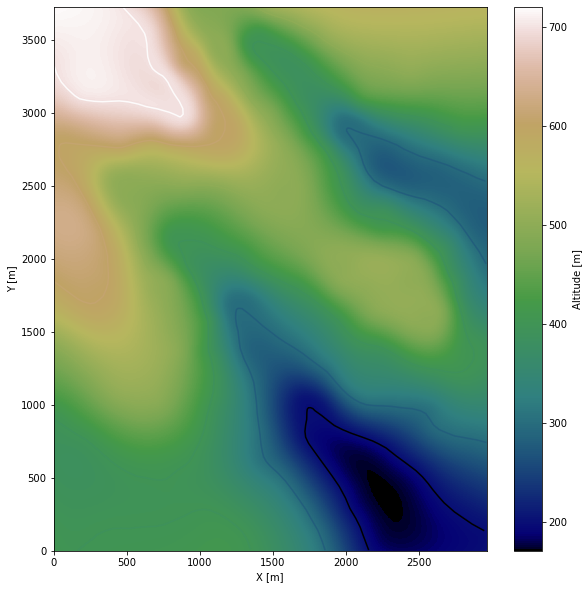

In [6]:
import matplotlib.pyplot as plt

fix, ax = plt.subplots(1, figsize=(10,10))
topo.plot(ax=ax, aspect='equal', column='Z', cmap='gist_earth')
im = plt.imshow(topo_raster, origin='lower', extent=[0,2966,0,3725], cmap='gist_earth')
cbar = plt.colorbar(im)
cbar.set_label('Altitude [m]')
plt.xlabel('X [m]')
plt.ylabel('Y [m]')

### Saving the raster to disc

After the interpolation of the contour lines, the raster is saved to disc using `gg.raster.save_as_tiff()`. The function will not be executed as a raster is already provided with the example data. 

gg.raster.save_as_tiff(raster=topo_raster, path=file_path + 'raster12.tif', extent=[0,2966,0,3725], crs='EPSG:4326', overwrite_file=True)

### Opening Raster

The previously computed and saved raster can now be opened using rasterio. 

In [7]:
topo_raster = rasterio.open(file_path + 'raster12.tif')

## Interface Points of stratigraphic boundaries

The interface points for this three point example will be digitized as points with the respective height value as given by the contour lines and the respective formation.  

<img src="../images/interfaces_example12.png" width="800">

In [8]:
interfaces = gpd.read_file(file_path + 'interfaces12.shp')
interfaces.head()

id formation    Z                   geometry
0  None      Coal  600   POINT (104.302 1770.385)
1  None      Coal  400  POINT (1696.262 1775.038)
2  None      Coal  200   POINT (1842.732 602.462)

### Extracting Z coordinate from Digital Elevation Model

In [9]:
interfaces_coords = gg.vector.extract_xyz(gdf=interfaces, dem=None)
interfaces_coords

formation      Z                   geometry       X       Y
0      Coal 600.00   POINT (104.302 1770.385)  104.30 1770.39
1      Coal 400.00  POINT (1696.262 1775.038) 1696.26 1775.04
2      Coal 200.00   POINT (1842.732 602.462) 1842.73  602.46

### Plotting the Interface Points

Text(53.5, 0.5, 'Y [m]')

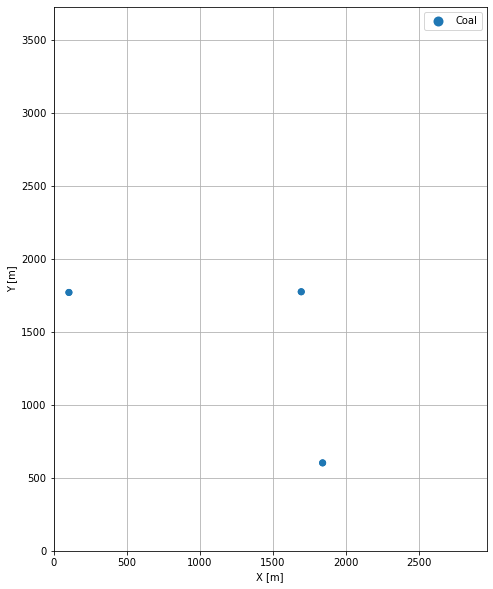

In [10]:
fig, ax = plt.subplots(1, figsize=(10,10))

interfaces.plot(ax=ax, column='formation', legend=True, aspect='equal')
interfaces_coords.plot(ax=ax, column='formation', legend=True, aspect='equal')
plt.grid()
plt.xlim(0,2966)
plt.ylim(0,3725)
plt.xlabel('X [m]')
plt.ylabel('Y [m]')

## Orientations from Strike Lines

For this three point example, an orientation is calculated using `gg.vector.calculate_orientation_for_three_point_problem()`. 

<img src="../images/orientations_example12.png" width="800">

In [11]:
orientations = gg.vector.calculate_orientation_for_three_point_problem(gdf=interfaces)
orientations

Z formation azimuth   dip polarity       X       Y  \
0 400.0      Coal  140.84 11.29        1 1214.43 1382.63   

                    geometry  
0  POINT (1214.432 1382.628)

In [12]:
orientations['Z'] = orientations['Z'].astype(float)
orientations['azimuth'] = orientations['azimuth'].astype(float)
orientations['dip'] = orientations['dip'].astype(float)
orientations['polarity'] = orientations['polarity'].astype(float)
orientations['X'] = orientations['X'].astype(float)
orientations['Y'] = orientations['Y'].astype(float)
orientations.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   Z          1 non-null      float64 
 1   formation  1 non-null      object  
 2   azimuth    1 non-null      float64 
 3   dip        1 non-null      float64 
 4   polarity   1 non-null      float64 
 5   X          1 non-null      float64 
 6   Y          1 non-null      float64 
 7   geometry   1 non-null      geometry
dtypes: float64(6), geometry(1), object(1)
memory usage: 192.0+ bytes


### Plotting the Orientations

Text(53.5, 0.5, 'Y [m]')

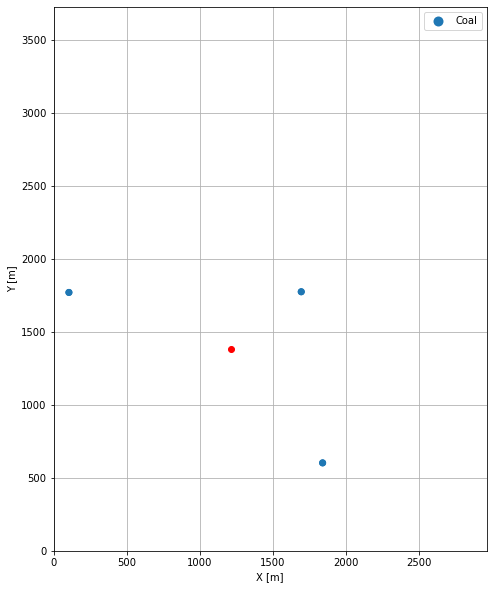

In [13]:
fig, ax = plt.subplots(1, figsize=(10,10))

interfaces.plot(ax=ax, column='formation', legend=True, aspect='equal')
interfaces_coords.plot(ax=ax, column='formation', legend=True, aspect='equal')
orientations.plot(ax=ax, color='red', aspect='equal')
plt.grid()
plt.xlim(0,2966)
plt.ylim(0,3725)
plt.xlabel('X [m]')
plt.ylabel('Y [m]')

## GemPy Model Construction

The structural geological model will be constructed using the `GemPy` package. 

In [14]:
import gempy as gp

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Creating new Model

In [15]:
geo_model = gp.create_model('Model12')
geo_model

Model12  2021-03-30 16:26

### Initiate Data

In [16]:
gp.init_data(geo_model, [0,2966,0,3725,0,1000], [100,100,100],
             surface_points_df = interfaces_coords[interfaces_coords['Z']!=0],
             orientations_df = orientations,
             default_values=True)

Active grids: ['regular']


Model12  2021-03-30 16:26

### Model Surfaces

In [17]:
geo_model.surfaces

surface          series  order_surfaces    color  id
0    Coal  Default series               1  #015482   1

### Mapping the Stack to Surfaces

In [18]:
gp.map_stack_to_surfaces(geo_model,
                         {
                          'Strata1': ('Coal'),
                         },
                         remove_unused_series=True)
geo_model.add_surfaces('Basement')

surface   series  order_surfaces    color  id
0      Coal  Strata1               1  #015482   1
1  Basement  Strata1               2  #9f0052   2

### Showing the Number of Data Points

In [19]:
gg.utils.show_number_of_data_points(geo_model=geo_model)

surface   series  order_surfaces    color  id  No. of Interfaces  No. of Orientations
0      Coal  Strata1               1  #015482   1                  3                    1
1  Basement  Strata1               2  #9f0052   2                  0                    0

### Loading Digital Elevation Model

In [20]:
geo_model.set_topography(
    source='gdal', filepath=file_path + 'raster12.tif')

Cropped raster to geo_model.grid.extent.
depending on the size of the raster, this can take a while...
storing converted file...
Active grids: ['regular' 'topography']


Grid Object. Values: 
array([[  14.83      ,   18.625     ,    5.        ],
       [  14.83      ,   18.625     ,   15.        ],
       [  14.83      ,   18.625     ,   25.        ],
       ...,
       [2958.51010101, 3687.44959677,  556.33007812],
       [2958.51010101, 3702.46975806,  558.58599854],
       [2958.51010101, 3717.48991935,  560.82910156]])

### Plotting Input Data

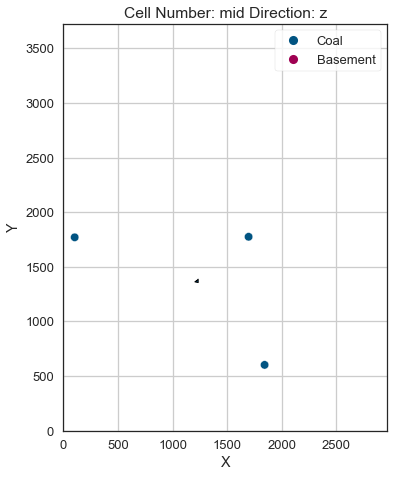

In [21]:
gp.plot_2d(geo_model, direction='z', show_lith=False, show_boundaries=False)
plt.grid()

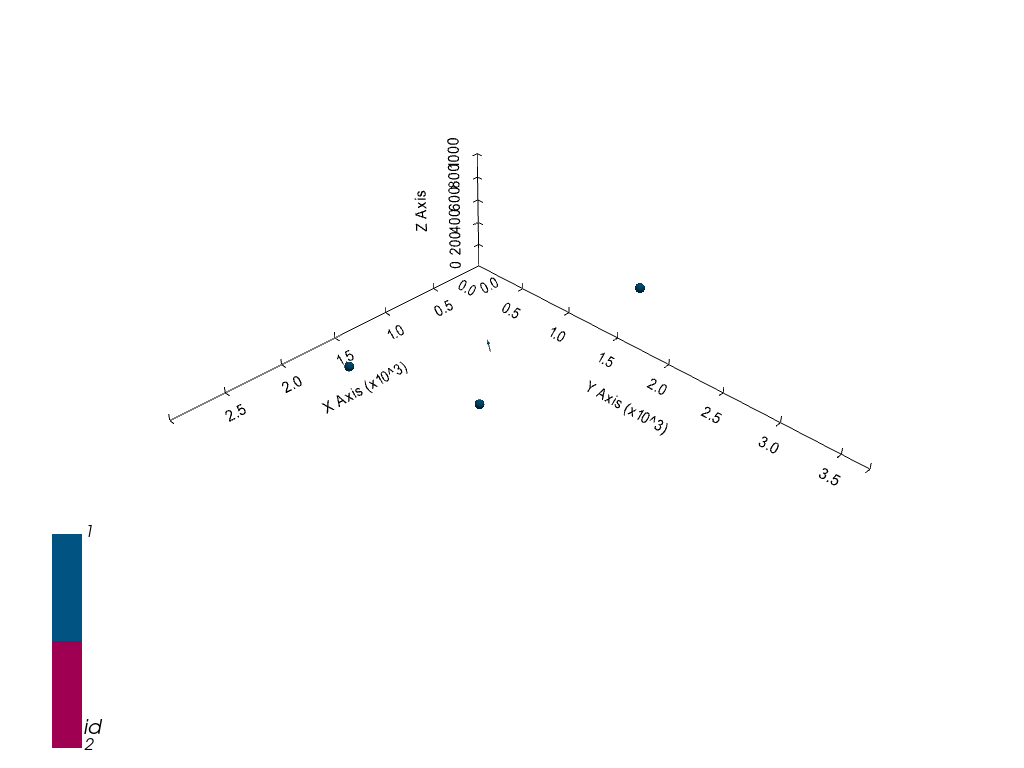

In [22]:
gp.plot_3d(geo_model, image=False, plotter_type='basic', notebook=True)

### Setting the Interpolator

In [23]:
gp.set_interpolator(geo_model,
                    compile_theano=True,
                    theano_optimizer='fast_compile',
                    verbose=[],
                    update_kriging = False
                    )

Compiling theano function...
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                    values
range             4865.47
$C_o$           563637.64
drift equations       [3]


### Computing Model

In [24]:
sol = gp.compute_model(geo_model, compute_mesh=True)

### Plotting Cross Sections

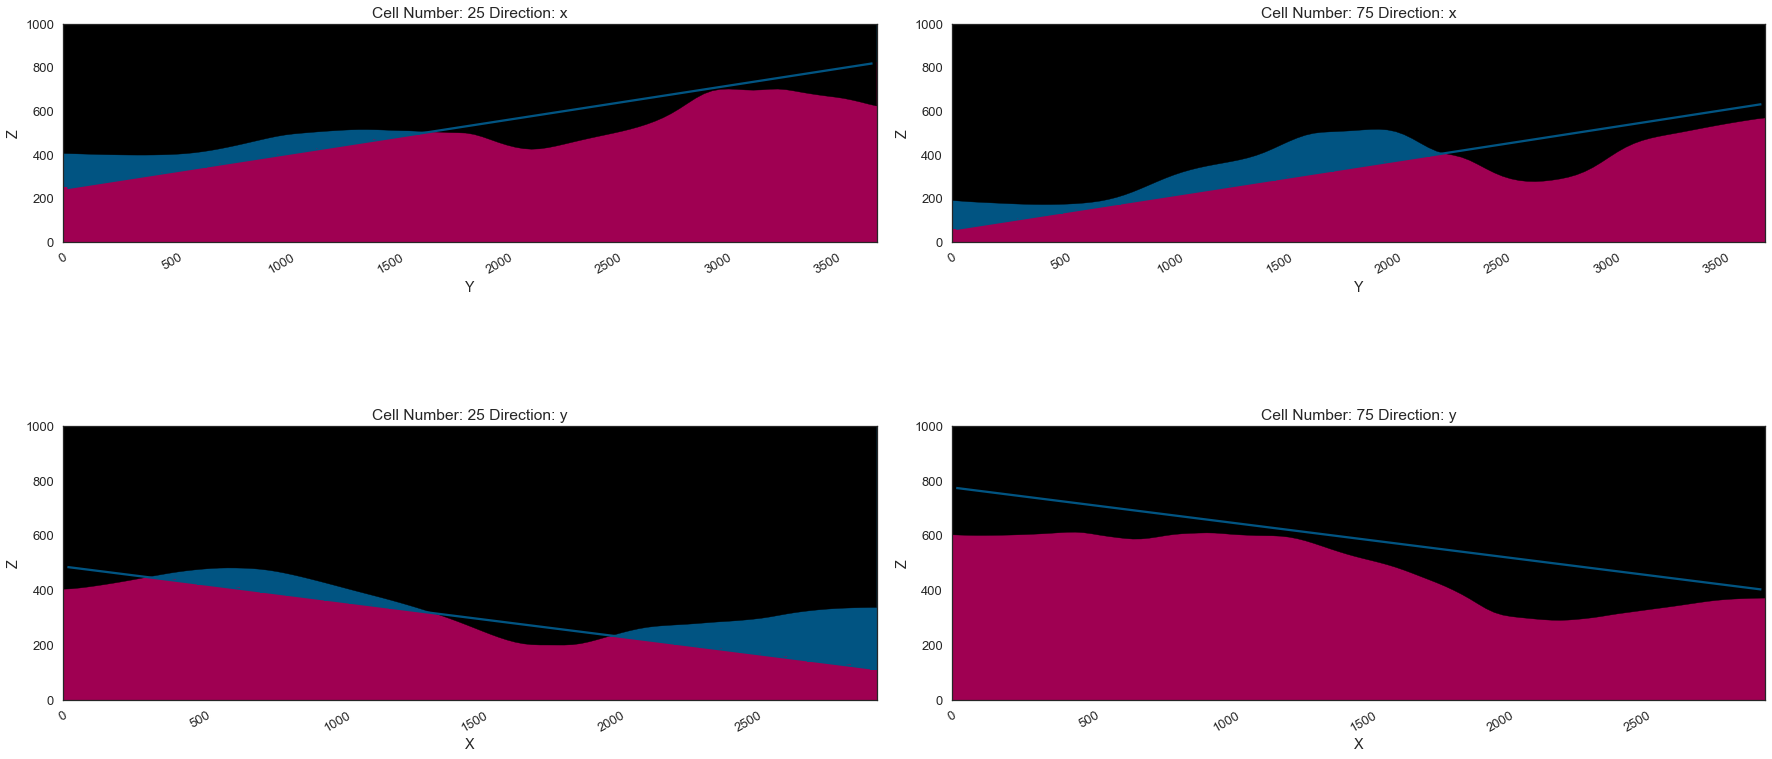

In [25]:
gp.plot_2d(geo_model, direction=['x', 'x', 'y', 'y'], cell_number=[25,75,25,75], show_topography=True, show_data=False)

### Plotting 3D Model

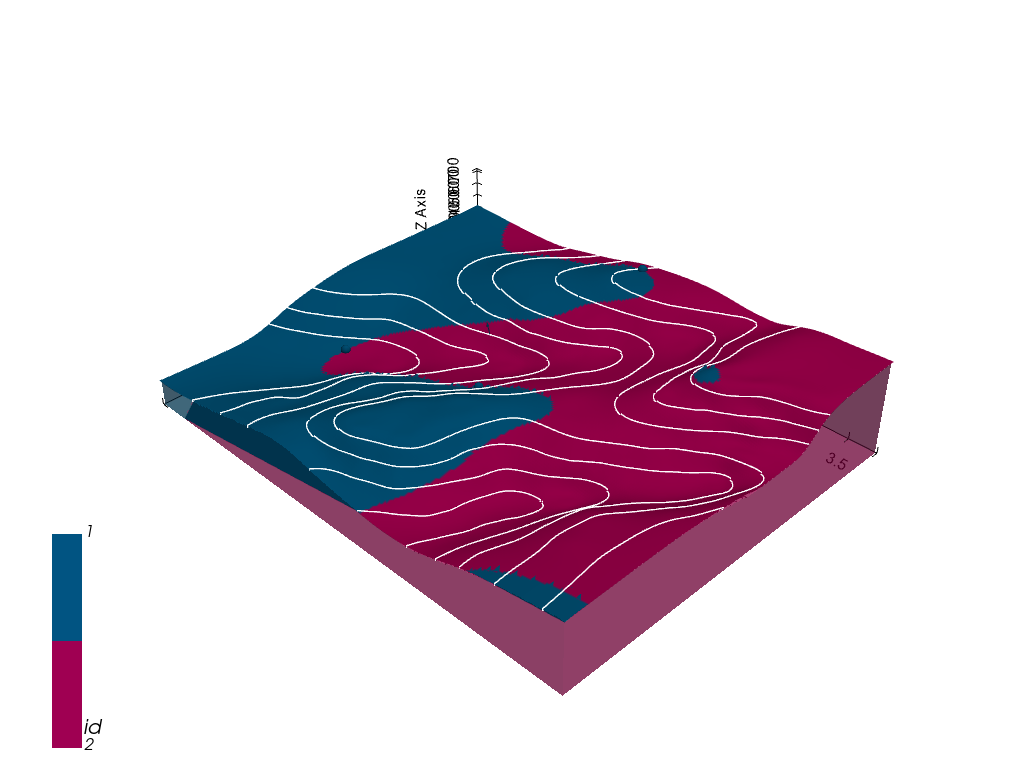

In [26]:
gpv = gp.plot_3d(geo_model, image=False, show_topography=True,
                 plotter_type='basic', notebook=True, show_lith=True)